In [82]:
%matplotlib inline 
#widget
import sys 
import xarray as xr
import numpy as np
import os 
import warnings
import yaml
from random import randint
import math
from datetime import datetime, timedelta
from parcels import FieldSet, Field, VectorField, ParticleSet, JITParticle, ParcelsRandom, Variable

sys.path.append('/home/jvalenti/MOAD/analysis-jose/Source')
from OP_functions import *

In [83]:
config = ['/home/jvalenti/scratch/OParcels_runs/Parcels_outfall/outfall_runs.yaml']
restart = 0
path_runs = '/home/jvalenti/MOAD/results/Graham/' 
paths = path(0)
# Suppress FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)

path_NEMO = make_prefix(datetime(2019, 1, 1),paths['NEMO'])
jjii = xr.open_dataset('~/MOAD/grid/grid_from_lat_lon_mask999.nc')
def finder(lati,loni):
    j = [jjii.jj.sel(lats=lati, lons=loni, method='nearest').item()][0]
    i = [jjii.ii.sel(lats=lati, lons=loni, method='nearest').item()][0]
    return j,i

In [84]:
finder(49.10891800952296, -123.25364922146802)

(425, 300)

In [85]:
coords = xr.open_dataset('/home/jvalenti/MOAD/grid/coordinates_seagrid_SalishSea201702.nc', decode_times=False)
mask = xr.open_dataset('/home/jvalenti/MOAD/grid2/mesh_mask202108_TDV.nc')

Text(0.5, 1.0, 'Salish Sea subregions')

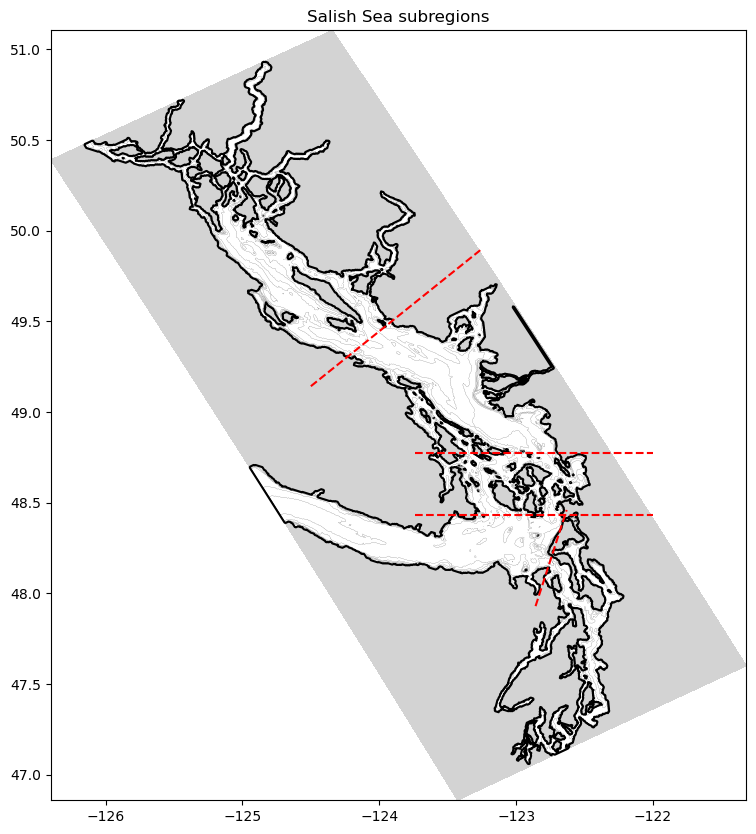

In [86]:

from matplotlib import pyplot as plt, animation, rc,colors
import cmocean
cm = cmocean.cm.dense

fig, ax = plt.subplots(1,1,figsize=(10, 10))

ax.contour(coords.nav_lon, coords.nav_lat, mask.mbathy[0,:,:],colors='k',linewidths=0.1)
ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
#aa = ax.hist2d(DS.lon,DS.lat,100,cmap =cm,vmin=1e-5,vmax=2000)
ax.set_aspect(1/np.sin(np.deg2rad(49)))
Xline = np.linspace(-124.5,-122,100)
yline0 = (7/3)*Xline+334.6
yline1 = (20/33)*Xline+124.597
yline2 = np.zeros_like(Xline)+48.43
yline3 = np.zeros_like(Xline)+48.774
plt.plot(Xline[65:75],yline0[65:75],'r--')
plt.plot(Xline[:50],yline1[:50],'r--')
plt.plot(Xline[30:],yline2[30:],'r--')
plt.plot(Xline[30:],yline3[30:],'r--')

plt.title('Salish Sea subregions')

In [87]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [88]:
# runs = {'Jan':['Run_Enero20190101_.nc',1],'Feb':['Run_Febrero20190201_.nc',32],'Mar':['Run_Marzo20190301_.nc',61],'Apr':['Run_Abril20190401_.nc',91],'Jun':['Run_Junio20190601_.nc',152],'Jul':['Run_Julio20190701_.nc',183],'Aug':['Run_Agosto20190801_.nc',214]}
# travel_all = np.zeros([len(runs),260000])
# for ii,months in enumerate(runs):
#     print(months)
#     ds = xr.open_dataset(path_runs+runs[months][0], decode_times=False)
#     x = np.linspace(0,31,ds.dims['obs']-1)
#     DS = ds.to_dataframe()
#     DS = DS.dropna()
    
#     dist_travel = []
#     for i in range(DS.lat.index[-1][0]):
#         try: leni = len(DS.lat[i])
#         except KeyError:
#             break
#         dist_travel.append(haversine(DS.lat[i][0],DS.lon[i][0],DS.lat[i][leni-1],DS.lon[i][leni-1]))
#     travel_all[ii,:len(dist_travel)]=dist_travel
# np.save('distance_travelled.npy',np.array(travel_all))

In [89]:
travel_all = np.load('distance_travelled.npy')

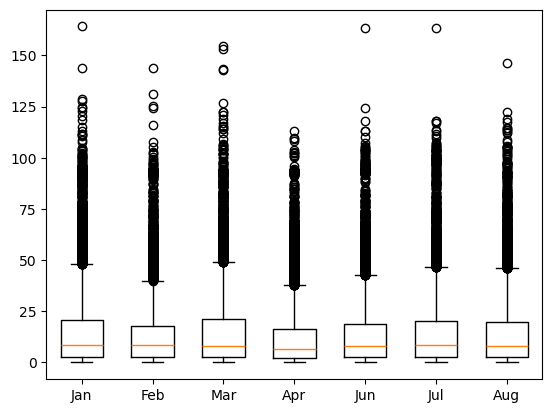

In [90]:
for i, label in enumerate(['Jan', 'Feb','Mar','Apr','Jun','Jul','Aug']):
    data = travel_all[i, :15000]
    data = data[data > 0]          # remove invalid values
    plt.boxplot(data/1e3, positions=[i], widths=0.6)

plt.xticks([0, 1,2,3,4,5,6], ['Jan', 'Feb','Mar','Apr','Jun','Jul','Aug'])
plt.show()

In [91]:
def cutting2(data,area):
    if area=='Puget':
        traj_keep = ((data.xs(0, level="obs").lat <48.43) & (data.xs(0, level='obs').lat <7/3* data.xs(0, level='obs').lon + 334.6))
        data_new = data.loc[pd.IndexSlice[traj_keep.index[traj_keep], :]]
    elif area=='JdF':
        traj_keep0 = ((data.xs(0, level="obs").lat <48.43) & (data.xs(0, level='obs').lat > 7/3* data.xs(0, level='obs').lon + 334.6))
        traj_keep = ((data.xs(0, level="obs").lat >48.43) & (data.xs(0, level='obs').lat <48.774) & (data.xs(0, level='obs').lon<-124))
        data_new0 = data.loc[pd.IndexSlice[traj_keep0.index[traj_keep0], :]]
        data_new1 = data.loc[pd.IndexSlice[traj_keep.index[traj_keep], :]]
        data_new = pd.concat([data_new0,data_new1])
    elif area=='Haro':  
        traj_keep = ((data.xs(0, level="obs").lat >48.43) & (data.xs(0, level='obs').lat <48.774) & (data.xs(0, level='obs').lon>-124) & (data.xs(0, level='obs').lon<-123) )
        data_new = data.loc[pd.IndexSlice[traj_keep.index[traj_keep], :]]
    elif area=='Rosario':
        traj_keep = ((data.xs(0, level="obs").lat >48.43) & (data.xs(0, level='obs').lat <48.774) & (data.xs(0, level='obs').lon>-123) )
        data_new = data.loc[pd.IndexSlice[traj_keep.index[traj_keep], :]]
    elif area=='Haro2':  
        traj_keep = ((data.xs(0, level="obs").lat >48.43) & (data.xs(0, level='obs').lat <48.774) & (data.xs(0, level='obs').lon>-124) )
        data_new = data.loc[pd.IndexSlice[traj_keep.index[traj_keep], :]]
    elif area=='NSoG':
        traj_keep = ((data.xs(0, level="obs").lat > (20/33)*data.xs(0, level="obs").lon+124.597))
        data_new = data.loc[pd.IndexSlice[traj_keep.index[traj_keep], :]]
    elif area=='CSSoG': 
        traj_keep = ((data.xs(0, level="obs").lat >48.774) & (data.xs(0, level="obs").lat < (20/33)*data.xs(0, level="obs").lon+124.597))
        data_new = data.loc[pd.IndexSlice[traj_keep.index[traj_keep], :]]
    else:
        print('Unrecognized subarea') 
        data_new = data
    return data_new

In [92]:
def counting(DS,month):
    DSb = DS[DS.status==2]
    DSe = DS[DS.status==3]
    DSs = DS[DS.status==1]
    count = []
    countb = []
    counte = []
    depthb = []
    for i in range(ds.dims['obs']-1):
        times= np.min(DS.time)+i*6*3600
        count.append(len(DSs[DSs.time == times]))
        counte.append(len(DSe[DSe.time == times]))
        countb.append(len(DSb[DSb.time == times]))

    beached = [(c - countb[i-1])*4/(count[i-1]) for i,c in enumerate(countb)]#*4 to give the units in day-1
    sediment = [(c - counte[i-1])*4/(count[i-1]) for i,c in enumerate(counte)]
    beached = np.array(beached)
    for i,b in enumerate(beached):
        if b==0:
            try:
                beached[i]=(beached[i-1]+beached[i+1])/2
            except IndexError:
                beached[i]=beached[i-1]

    sediment = np.array(sediment)
    for i,b in enumerate(sediment):
        if b==0:
            try:
                sediment[i]=(sediment[i-1]+sediment[i+1])/2
            except IndexError:
                sediment[i] = sediment[i-1]
            
    return 1/beached[1:],1/sediment[1:],count

In [93]:
import pandas as pd
Point_At = pd.read_csv('Book1.csv')
Time=np.linspace(0,365,8017)
#

In [94]:
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great-circle distance between two points on the Earth.
    Parameters:
        lat1, lon1: Latitude and longitude of point 1 in decimal degrees.
        lat2, lon2: Latitude and longitude of point 2 in decimal degrees.
    Returns:
        Distance in kilometers.
    """
    # Convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    r = 6371000 # Radius of Earth in kilometers
    return r * c

In [95]:
# import matplotlib.patches as mpatches
# import matplotlib.pyplot as plt

# path_runs = '/home/jvalenti/MOAD/results/Graham/MFpaper/'
# runs = {'Jan':['Run_Enero20190101_.nc',1],'Feb':['Run_Febrero20190201_.nc',32],'Mar':['Run_Marzo20190301_.nc',61],'Apr':['Run_Abril20190401_.nc',91],'Jun':['Run_Junio20190601_.nc',152],'Jul':['Run_Julio20190701_.nc',183],'Aug':['Run_Agosto20190801_.nc',214]}
# fig,axs = plt.subplots(2,2,figsize=(15,10))
# #twin1 = axs[0,1].twinx()
# twin2 = axs[1,1].twinx()
# twin3 = axs[1,0].twinx()
# axs[1,1].plot(Time,np.array(Point_At.ssh[1:],dtype='f'),c='grey',alpha=0.4,label='SSH')
# for month in runs:
#     ds = xr.open_dataset(path_runs+runs[month][0], decode_times=False)
#     x = np.linspace(runs[month][1],int(runs[month][1]+ds.dims['obs']/4),ds.dims['obs']-1)
#     x2 = np.linspace(0,30,ds.dims['obs']-1)
#     DS = ds.to_dataframe()
#     DS = DS.dropna()
#     DS = DS[DS.time>0]
#     DS = DS[DS.lat<48]
#     counting(DS,month,axs)
# axs[0,0].legend()
# legend_lines = [plt.Line2D([0], [0], color='black', linestyle='-'),
#                 plt.Line2D([0], [0], color='black', linestyle='--')]
# axs[1,0].legend(legend_lines,['Sedimented','Beached'], loc = 'upper left')
# axs[0,1].legend(legend_lines,['Bch Rate','Avg Depth'], loc = 'center right')

# solid_block = mpatches.Patch(color='lightgrey', label='Solid Block')
# legend_lines2 = [solid_block,
#                 plt.Line2D([0], [0], color='black', linestyle='-')]

# axs[1,1].legend(legend_lines2,['SSH','Sed Rate'], loc = 'upper right')

In [96]:
puget_vol = mask.volume.where((coords.nav_lat<48.43) & (coords.nav_lat<(7/3)*coords.nav_lon+334.6)).sum()
haro2_vol= mask.volume.where((coords.nav_lat>48.43) & (coords.nav_lat<48.774) & (coords.nav_lon>-124)).sum()
NSoG_vol = mask.volume.where((coords.nav_lat>(20/33)*coords.nav_lon+124.597)).sum()
CSSog_vol = mask.volume.where((coords.nav_lat>48.774)&(coords.nav_lat<(20/33)*coords.nav_lon+124.597)).sum()
jdf_vol = mask.volume.where((coords.nav_lat<48.43) & (coords.nav_lat>(7/3)*coords.nav_lon+334.6)).sum() + mask.volume.where(((coords.nav_lat>48.43) & (coords.nav_lat<48.774) & (coords.nav_lon<-124))).sum()

#puget2_vol = mask.volume.where((coords.nav_lat<48.43) & (coords.nav_lat<(7/3)*coords.nav_lon+334.6)&(coords.nav_lon> -122.766)).sum() #To trim Main Channel

sub_areas_vol={'Puget':puget_vol,'JdF':jdf_vol,'Haro2':haro2_vol,'NSoG':NSoG_vol,'CSSoG':CSSog_vol}


In [97]:
def cutting(data,area):
    if area=='Puget':
        data_new = data.loc[(data['lat']<48.43) & (data['lat']<(7/3)*data['lon']+334.6)]
    elif area=='JdF':
        data_new = pd.concat([data.loc[((data['lat']<48.43) & (data['lat']>(7/3)*data['lon']+334.6))],data.loc[((data['lat']>48.43) & (data['lat']<48.774) & (data['lon']<-124))]])
    elif area=='Haro':  
        data_new = data.loc[(data['lat']>48.43) & (data['lat']<48.774) & (data['lon']>-124)&(data['lon']<-123)]
    elif area=='Rosario':  
        data_new = data.loc[(data['lat']>48.43) & (data['lat']<48.774) & (data['lon']>-123)]
    elif area=='Haro2':  
        data_new = data.loc[(data['lat']>48.43) & (data['lat']<48.774) & (data['lon']>-124)]
    elif area=='NSoG':
        data_new = data.loc[(data['lat']>(20/33)*data['lon']+124.597)]
    elif area=='CSSoG': 
        data_new = data.loc[(data['lat']>48.774)&(data['lat']<(20/33)*data['lon']+124.597)]
    else:
        print('Unrecognized subarea') 
        data_new = data
    return data_new

In [98]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
sub_areas=['Puget','JdF','Haro2','NSoG','CSSoG']

path_runs = '/home/jvalenti/MOAD/results/Graham/MFpaper/'
runs = {'Jan':['Run_Enero20190101_.nc',1],'Feb':['Run_Febrero20190201_.nc',32],'Mar':['Run_Marzo20190301_.nc',61],'Apr':['Run_Abril20190401_.nc',91],'Jun':['Run_Junio20190601_.nc',152],'Jul':['Run_Julio20190701_.nc',183],'Aug':['Run_Agosto20190801_.nc',214]}

beach_all = np.zeros([150,len(runs),len(sub_areas)])
sediment_all = np.zeros([150,len(runs),len(sub_areas)])
count_all = np.zeros([150,len(runs),len(sub_areas)])


for ii,month in enumerate(runs):
    ds = xr.open_dataset(path_runs+runs[month][0], decode_times=False)
    x = np.linspace(runs[month][1],int(runs[month][1]+ds.dims['obs']/4),ds.dims['obs']-1)
    x2 = np.linspace(0,30,ds.dims['obs']-1)
    DS = ds.to_dataframe()
    DS = DS.dropna()
    DS = DS[DS.time>0]
    for j,area in enumerate(sub_areas):
        DSn = cutting(DS,area)
        beach,sediment,counts= counting(DSn,month)
        beach_all[:len(beach),ii,j]=beach
        count_all[:len(counts),ii,j]=counts/sub_areas_vol[area].values
        sediment_all[:len(sediment),ii,j]=sediment

np.save('beached_months2.npy',np.array(beach_all))
np.save('suspended_months2.npy',np.array(count_all))
np.save('sediments_months2.npy',np.array(sediment_all))

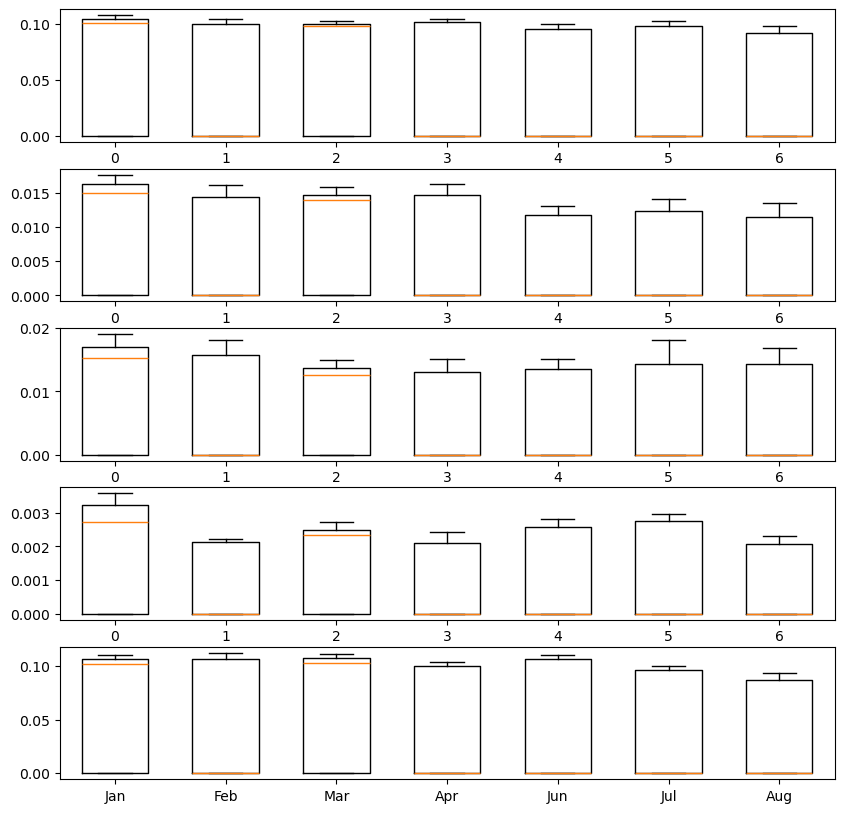

In [101]:
fig,axs = plt.subplots(5,1,figsize=(10,10))
for j,sub_areass in enumerate(sub_areas):
    for i, label in enumerate(['Jan', 'Feb','Mar','Apr','Jun','Jul','Aug']):
        data = count_all[90:,i,j]
        data = data[~np.isnan(data)]*1e7  
        axs[j].boxplot(data, positions=[i], widths=0.6,showfliers=False)

plt.xticks([0, 1,2,3,4,5,6], ['Jan', 'Feb','Mar','Apr','Jun','Jul','Aug'])
plt.show()

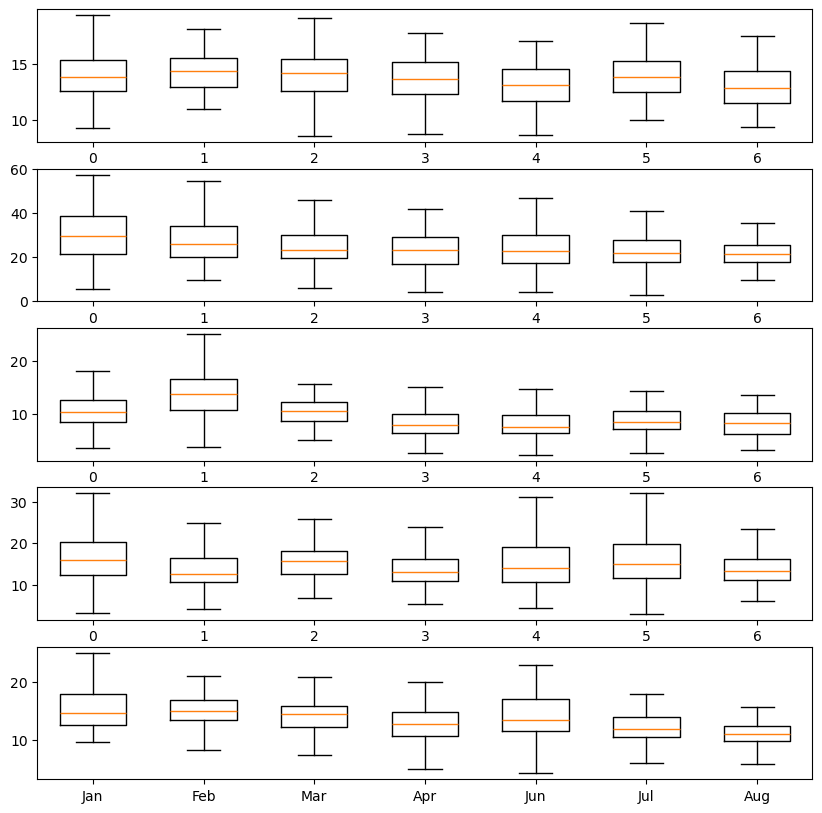

In [102]:


fig,axs = plt.subplots(5,1,figsize=(10,10))
for j,sub_areass in enumerate(sub_areas):
    for i, label in enumerate(['Jan', 'Feb','Mar','Apr','Jun','Jul','Aug']):
        data = sediment_all[:,i,j]
        data = data[data > 0]   
        axs[j].boxplot(data, positions=[i], widths=0.6,showfliers=False)

plt.xticks([0, 1,2,3,4,5,6], ['Jan', 'Feb','Mar','Apr','Jun','Jul','Aug'])
plt.show()

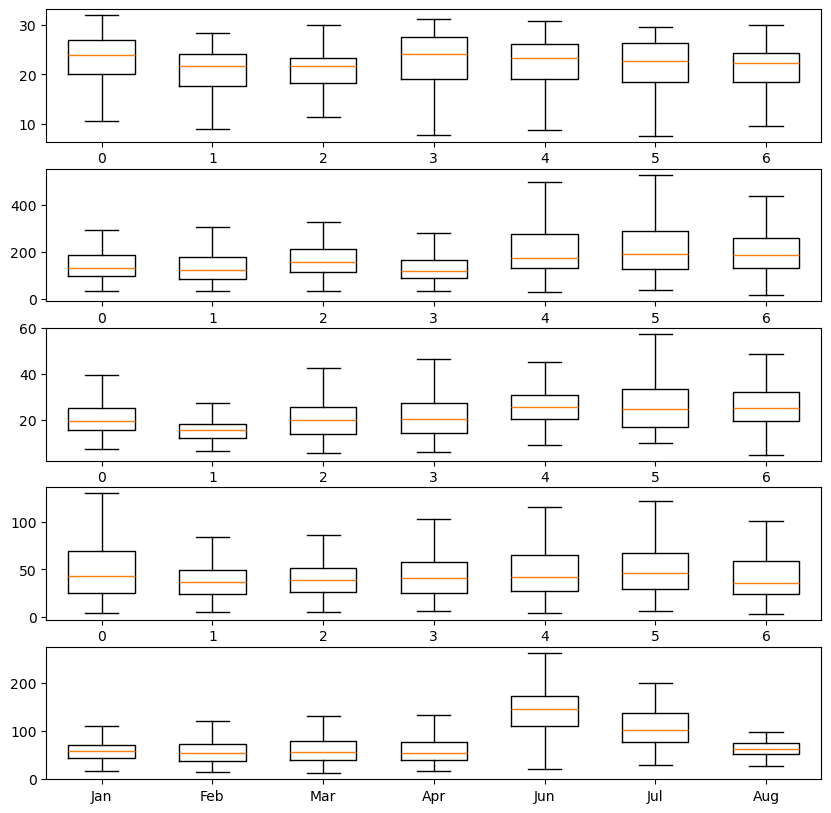

In [103]:


fig,axs = plt.subplots(5,1,figsize=(10,10))
for j,sub_areass in enumerate(sub_areas):
    for i, label in enumerate(['Jan', 'Feb','Mar','Apr','Jun','Jul','Aug']):
        data = beach_all[:,i,j]
        data = data[data > 0]   
        axs[j].boxplot(data, positions=[i], widths=0.6,showfliers=False)

plt.xticks([0, 1,2,3,4,5,6], ['Jan', 'Feb','Mar','Apr','Jun','Jul','Aug'])
plt.show()